# Building an AI-powered multimodal RAG system with Docling and Granite

*Using IBM Granite vision, text-based embeddings and generative AI models*

## Multimodal retrieval-augmented generation

[Retrieval-augmented generation (RAG)](https://www.ibm.com/think/topics/retrieval-augmented-generation) is a technique used with large language models (LLMs) to connect the model with a knowledge base of information outside the data the LLM has been trained on without having to perform [fine-tuning](https://www.ibm.com/think/topics/rag-vs-fine-tuning). Traditional RAG is limited to text-based use cases such as text summarization and chatbots.

Multimodal RAG can use [multimodal](https://www.ibm.com/think/topics/multimodal-ai) LLMs (MLLM) to process information from multiple types of data to be included as part of the external knowledge base used in RAG. Multimodal data can include text, images, audio, video or other forms. Popular multimodal LLMs include Google’s Gemini, Meta’s Llama 3.2 and OpenAI’s GPT-4 and GPT-4o.

For this recipe, you will use an IBM Granite model capable of processing different modalities. You will create an AI system to answer real-time user queries from unstructured data in a PDF.

## Recipe overview

Welcome to this Granite recipe. In this recipe, you'll learn how to harness the power of advanced tools to build an AI-powered multimodal RAG pipeline. This tutorial will guide you through the following processes:

- **Document preprocessing:** Learn how to handle documents from various sources, parse and transform them into usable formats and store them in vector databases by using Docling. You will use a Granite MLLM to generate image descriptions of images in the documents.
- **RAG:** Understand how to connect LLMs such as Granite with external knowledge bases to enhance query responses and generate valuable insights.
- **LangChain for workflow integration:** Discover how to use LangChain to streamline and orchestrate document processing and retrieval workflows, enabling seamless interaction between different components of the system.

This recipe uses three cutting-edge technologies:

1. **[Docling](https://docling-project.github.io/docling/):** An open-source toolkit used to parse and convert documents.
2. **[Granite](https://www.ibm.com/granite/docs/models/granite/):** A state-of-the-art LLM that provides robust natural language capabilities and a vision language model that provides image to text generation.
3. **[LangChain](https://github.com/langchain-ai/langchain):** A powerful framework used to build applications powered by language models, designed to simplify complex workflows and integrate external tools seamlessly.

By the end of this recipe, you will accomplish the following:
- Gain proficiency in document preprocessing, chunking and image understanding.
- Integrate vector databases to enhance retrieval capabilities.
- Use RAG to perform efficient and accurate data retrieval for real-world applications.

This recipe is designed for AI developers, researchers and enthusiasts looking to enhance their knowledge of document management and advanced natural language processing (NLP) techniques.


## Prerequisites

- Familiarity with Python programming.
- Basic understanding of LLMs, NLP concepts and computer vision.

## Step 1: Setting up the environment

Install dependencies.

In [1]:
! echo "::group::Pip Install Dependencies"
%pip install "git+https://github.com/ibm-granite-community/utils.git" \
    transformers \
    pillow \
    langchain_community \
    'langchain_huggingface[full]' \
    langchain_milvus \
    docling \
    replicate
! echo "::endgroup::"

::group::Pip Install Dependencies
  Cloning https://github.com/ibm-granite-community/utils.git to /tmp/pip-req-build-xh0fhxv_
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite-community/utils.git /tmp/pip-req-build-xh0fhxv_
  Resolved https://github.com/ibm-granite-community/utils.git to commit 68309388c1f857d25a6fe680caedb6d4cc1dcdaf
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.7/223.7 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.1/164.

## Step 2: Selecting the AI models

### Logging

To see some logging information, we can configure INFO log level.

NOTE: It is okay to skip running this cell.

In [2]:
import logging

logging.basicConfig(level=logging.INFO)

### Load the Granite models

Specify the embeddings model to use for generating text embedding vectors. Here we will use one of the [Granite Embeddings models](https://huggingface.co/collections/ibm-granite/granite-embedding-models-6750b30c802c1926a35550bb)

To use a different embeddings model, replace this code cell with one from [this Embeddings Model recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Embeddings_Models.ipynb).

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import AutoTokenizer

embeddings_model_path = "ibm-granite/granite-embedding-30m-english"
embeddings_model = HuggingFaceEmbeddings(
    model_name=embeddings_model_path,
)
embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/60.6M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Specify the MLLM to use for image understanding. We will use the Granite vision model.

In [4]:
from ibm_granite_community.notebook_utils import get_env_var
from langchain_community.llms import Replicate
from transformers import AutoProcessor

vision_model_path = "ibm-granite/granite-vision-3.3-2b"
vision_model = Replicate(
    model=vision_model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": embeddings_tokenizer.max_len_single_sentence, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
    },
)
vision_processor = AutoProcessor.from_pretrained(vision_model_path)

REPLICATE_API_TOKEN loaded from Google Colab secret.


processor_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

Specify the language model to use for the RAG generation operation. Here we use the Replicate LangChain client to connect to a Granite model from the [`ibm-granite`](https://replicate.com/ibm-granite) org on Replicate.

To get set up with Replicate, see [Getting Started with Replicate](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started/Getting_Started_with_Replicate.ipynb).

To connect to a model on a provider other than Replicate, substitute this code cell with one from the [LLM component recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_LLMs.ipynb).

In [5]:
model_path = "ibm-granite/granite-3.3-8b-instruct"
model = Replicate(
    model=model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": 1000, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
    },
)
tokenizer = AutoTokenizer.from_pretrained(model_path)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/207 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

## Step 3: Preparing the documents for the vector database

In this example, from a set of source documents, we use [Docling](https://docling-project.github.io/docling/) to convert the documents into text and images. The text is then split into chunks. The images are processed by the MLLM to generate image summaries.

### Use Docling to download the documents and convert to text and images

Docling will download the PDF documents and process them so we can obtain the text and images the documents contain. In the PDF, there are various data types, including text, tables, graphs and images.

In [6]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions

pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,
    generate_picture_images=True,
)
format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}
converter = DocumentConverter(format_options=format_options)

sources = [
    "https://midwestfoodbank.org/images/AR_2020_WEB2.pdf",
]
conversions = { source: converter.convert(source=source).document for source in sources }

With the documents processed, we then further process the text elements in the documents. We chunk them into appropriate sizes for the embeddings model we are using. A list of LangChain documents are created from the text chunks.

In [7]:
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem
from langchain_core.documents import Document

doc_id = 0
texts: list[Document] = []
for source, docling_document in conversions.items():
    for chunk in HybridChunker(tokenizer=embeddings_tokenizer).chunk(docling_document):
        items = chunk.meta.doc_items
        if len(items) == 1 and isinstance(items[0], TableItem):
            continue # we will process tables later
        refs = " ".join(map(lambda item: item.get_ref().cref, items))
        print(refs)
        text = chunk.text
        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "ref": refs,
            },
        )
        texts.append(document)

print(f"{len(texts)} text document chunks created")

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


#/texts/1
#/texts/4 #/texts/5
#/texts/7 #/texts/8 #/texts/9 #/texts/10 #/texts/11 #/texts/12 #/texts/13
#/tables/0 #/texts/16 #/texts/17
#/texts/20
#/texts/22
#/texts/24
#/texts/26
#/texts/28
#/texts/30
#/texts/32
#/texts/34
#/texts/40 #/texts/41
#/texts/44
#/texts/46 #/texts/47 #/texts/48 #/texts/49 #/texts/50 #/texts/51 #/texts/52 #/texts/53 #/texts/54
#/texts/56
#/texts/58 #/texts/59 #/texts/60 #/texts/61 #/texts/62 #/texts/63
#/texts/138 #/texts/139
#/tables/1 #/texts/143 #/texts/151
#/texts/155 #/texts/156
#/texts/158 #/texts/159 #/texts/160
#/texts/164 #/texts/165 #/texts/166 #/texts/167
#/texts/169 #/texts/170 #/texts/171 #/texts/172 #/texts/173 #/texts/174 #/texts/175 #/texts/176 #/texts/177 #/texts/178
#/texts/190
#/texts/192 #/texts/193 #/texts/194 #/texts/195 #/texts/196
#/texts/199
#/texts/201
#/texts/203
#/texts/205
#/texts/207
#/texts/209
#/texts/211
#/texts/213
#/texts/215
#/texts/217
#/texts/219
#/texts/221
#/texts/223
#/texts/230 #/texts/231 #/texts/232
#/texts/234 #/t

Next we process any tables in the documents. We convert the table data to markdown format for passing into the language model. A list of LangChain documents are created from the table's markdown renderings.

In [8]:
from docling_core.types.doc.labels import DocItemLabel

doc_id = len(texts)
tables: list[Document] = []
for source, docling_document in conversions.items():
    for table in docling_document.tables:
        if table.label in [DocItemLabel.TABLE]:
            ref = table.get_ref().cref
            print(ref)
            text = table.export_to_markdown(docling_document)
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref
                },
            )
            tables.append(document)


print(f"{len(tables)} table documents created")

#/tables/1
1 table documents created


Finally we process any images in the documents. Here we use the vision language model to understand the content of an image. In this example, we are interested in any textual information in the image. You might want to experiment with different prompt text to see how it might improve the results.

NOTE: Processing the images can take a very long time depending upon the number of images and the service running the vision language model.

In [9]:
import base64
import io
import PIL.Image
import PIL.ImageOps
from ibm_granite_community.langchain import TokenizerChatPromptTemplate
from langchain_core.messages import HumanMessage

def encode_image(image: PIL.Image.Image, format: str = "png") -> str:
    image = PIL.ImageOps.exif_transpose(image) or image
    image = image.convert("RGB")

    buffer = io.BytesIO()
    image.save(buffer, format)
    encoding = base64.b64encode(buffer.getvalue()).decode("utf-8")
    uri = f"data:image/{format};base64,{encoding}"
    return uri

# Feel free to experiment with this prompt
image_prompt = "If the image contains text, explain the text in the image."
vision_prompt_template = TokenizerChatPromptTemplate.from_messages(
    messages=[
        HumanMessage(content=[
            {"type": "image"},
            {"type": "text", "text": image_prompt},
        ]),
    ],
    tokenizer=vision_processor)
vision_prompt = vision_prompt_template.format_prompt()

pictures: list[Document] = []
doc_id = len(texts) + len(tables)
for source, docling_document in conversions.items():
    for picture in docling_document.pictures:
        ref = picture.get_ref().cref
        print(ref)
        image = picture.get_image(docling_document)
        if image:
            text = vision_model.invoke(vision_prompt, images=[encode_image(image)])
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref,
                },
            )
            pictures.append(document)

print(f"{len(pictures)} image descriptions created")

#/pictures/0
#/pictures/1
#/pictures/2
#/pictures/3
#/pictures/4
#/pictures/5
#/pictures/6
#/pictures/7
#/pictures/8
#/pictures/9
#/pictures/10
#/pictures/11
#/pictures/12
#/pictures/13
#/pictures/14
#/pictures/15
#/pictures/16
#/pictures/17
#/pictures/18
#/pictures/19
#/pictures/20
#/pictures/21
#/pictures/22
#/pictures/23
#/pictures/24
#/pictures/25
#/pictures/26
#/pictures/27
#/pictures/28
#/pictures/29
#/pictures/30
#/pictures/31
#/pictures/32
#/pictures/33
#/pictures/34
#/pictures/35
#/pictures/36
#/pictures/37
#/pictures/38
#/pictures/39
#/pictures/40
#/pictures/41
#/pictures/42
#/pictures/43
#/pictures/44
#/pictures/45
#/pictures/46
#/pictures/47
#/pictures/48
#/pictures/49
#/pictures/50
#/pictures/51
#/pictures/52
#/pictures/53
54 image descriptions created


We can then display the LangChain documents created from the input documents.

Document ID: 1
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
bridging the gap between poverty and prosperity
Document ID: 2
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
No one could have predicted the events of 2020. The global COVID-19 pandemic created a dynamic year. With the help of volunteers, donors, staff, and most importantly, the blessings of God, Midwest Food Bank responded nimbly to the changing landscape.
All  MFB  locations  remained  open  and  responsive  to  the  need  of  our nonprofit partners. We enacted safety protocols and reduced volunteer numbers  to  maintain  social  distancing  guidelines.  To  allow  partner agencies to receive food from MFB safely, we altered our distribution model.  Community,  business,  and  donor  support  funded  operations and helped with food purchases. More details on our response to the pandemic are on page 14.
Document ID: 3
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Co

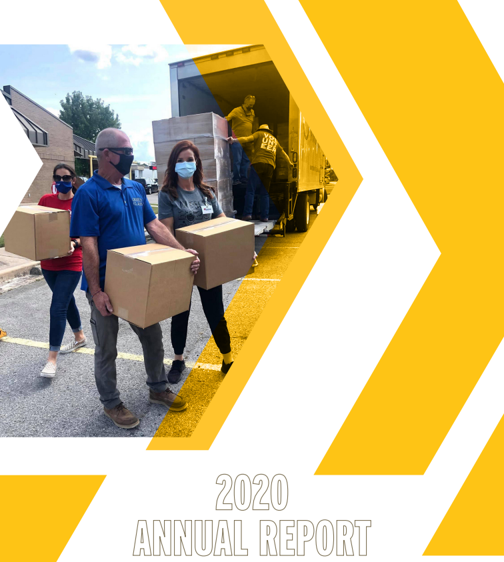

Document ID: 76
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "Midwest Food Bank." It is likely the name of an organization that deals with food distribution or relief services. The text is presented in a serif font, which is commonly used for formal or official documents. The logo accompanying the text suggests that the organization is involved with agriculture or food production, as indicated by the wheat stalk within the circular shape. The design is simple and clear, intended to be easily recognizable and memorable. The text and logo together convey a message of the organization's identity and purpose.
Image:


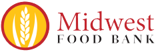

Document ID: 77
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a simple motivational statement: "KEEP MOVING FORWARD." This phrase is commonly used to encourage perseverance and progress, especially in the context of personal or professional development. It implies a message of optimism and the importance of taking action towards one's goals, despite challenges or setbacks. The text is presented in a clear, sans-serif font, which is typical for motivational content, designed to be easily readable and to convey a message quickly and effectively.
Image:


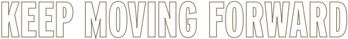

Document ID: 78
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible. It appears to be a form of abstract text, possibly intended to be read as a series of shapes or symbols. Without a clearer image or additional context, it is not possible to provide a precise transcription of the text. If the text is meant to be read, it would be best to use optical character recognition (OCR) software to convert the image into editable text. However, it is important to note that the use of OCR on images containing text should be done with respect for privacy and intellectual property rights.
Image:


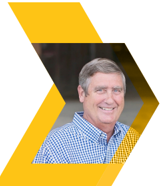

Document ID: 79
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not clear or legible. It is obscured by the yellow geometric shape that is overlaid on the image. This shape appears to be a creative element rather than text, and it does not contain any text that can be read or interpreted. Without a clear view of the text, it is not possible to provide an accurate description or transcription of its content. If the text is meant to be readable, it would be best viewed in a setting where the text is not obscured by other objects or design elements.
Image:


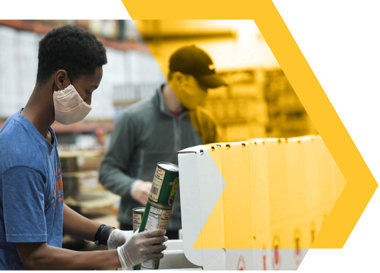

Document ID: 80
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "Facebook Instagram LinkedIn," which is the branding for the three major social media platforms. These are commonly used for personal and professional networking, sharing content, and connecting with others. The logos represent the unique branding of each platform, designed to be easily recognizable and memorable. The use of the word "in" in the third logo might be a typographical error or a creative choice, as it does not fit the context of the other logos.
Image:


Document ID: 81
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text present in the image is on the cardboard box and reads "Midwest Food Bank." This is indicative of the organization involved in the activity depicted. The Midwest Food Bank is a well-known nonprofit organization that provides food to those in need in the Midwest region of the United States. The text is likely part of a promotional or informational campaign, given the context of the image and the presence of the person wearing a protective mask, which suggests a health-related campaign or initiative.
Image:


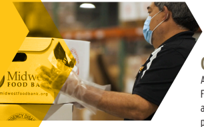

Document ID: 82
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains no text. It is a simple icon designed to symbolize assistance or support, typically used in digital interfaces to indicate a function or service related to help, support, or community interaction. The hands are a universal symbol for aid and cooperation, and their positioning suggests a gesture of giving or receiving help. This icon is commonly used in applications, websites, and mobile apps to represent a feature that involves collaboration or assistance. The absence of text allows for a universal understanding of the icon's meaning, transcending language barriers.
Image:


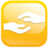

Document ID: 83
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a logo, which is a graphic mark or emblem that is used to identify a company, product, or organization. Logos are typically designed to be memorable and to convey the essence of the brand quickly. They are used in a wide range of media and products, from websites and mobile applications to clothing, cars, and more. The text within the image is stylized to represent a person, which could suggest that the brand is related to human activity, fitness, or well-being. Without clearer text or additional context, it is not possible to provide a more specific interpretation of the text.
Image:


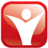

Document ID: 84
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image cannot be discerned due to the resolution and the abstract nature of the graphic. It appears to be a stylized representation of text, possibly meant to convey a message or represent a concept, but without clearer text or additional context, it is not possible to provide an accurate transcription or interpretation. If the image is intended to contain text, it may be a placeholder or a design element meant to symbolize something specific to the context it is used in, such as a brand logo or a symbol for a concept like community or collaboration.
Image:


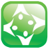

Document ID: 85
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that reads "ELECTRONIC COMMUNICATIONS." This text is likely part of a larger text that is not fully visible in the image. Given the context of the shield and the color scheme, it could be part of a branding or a label for a product or service related to electronic communication. The text is in all caps, which is a common typographical choice for emphasis or to denote a brand name. The image does not provide any additional text that can be read or explained beyond what is visible.
Image:


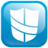

Document ID: 86
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible due to the low resolution and blurriness of the image. Therefore, it is not possible to provide a transcription or detailed description of the text. If the image contains text that is intended to be readable, it would be recommended to use a higher resolution image or a clearer source to ensure accurate text transcription. If the text is part of a larger message or graphic, additional context would be needed to provide a meaningful interpretation. In this case, any attempt to transcribe or describe the text would be speculative and not reliable.
Image:


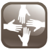

Document ID: 87
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible due to the resolution and angle of the photograph. It appears to be a label or information label, possibly related to the contents of the boxes, but the specific text cannot be accurately described or interpreted. Without clearer text or additional context, it is not possible to provide a detailed analysis or transcription of the text. If the text is crucial for understanding the image, it would be recommended to either obtain a higher-resolution image or provide a clearer textual description for analysis.
Image:


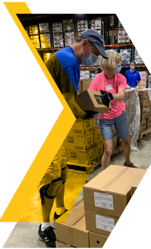

Document ID: 88
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured and not fully legible. However, from what can be seen, it appears to be a statement or a caption that is likely related to the subject of the image. It could be part of a title, a statement made by the person in the photo, or a slogan associated with the event or organization. Without clearer text, it is not possible to provide a detailed interpretation of the message. If the text is intended to convey specific information, it would be best to have a clearer image or additional context to ensure accurate understanding.
Image:


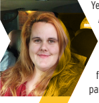

Document ID: 89
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, making it difficult to read in full. However, it appears to be part of a larger message or statement. The visible portion of the text reads "ban pan Hope," which could be part of a slogan or a message. Without the full context, it's challenging to provide a precise interpretation. If the text is part of a larger message, it might relate to a campaign, a cause, or a message of encouragement. To understand the full text, one would need additional information or a clearer view of the entire image.
Image:


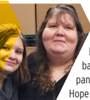

Document ID: 90
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "««". It is an incomplete text, commonly used in online communication to indicate that something is being omitted or is a placeholder. It is not a specific text that can be translated or described further without additional context. The use of double quotation marks is a common typographical convention to denote speech or a quote. However, in this case, it is used to represent a missing or incomplete text. The image does not contain any other text that can be described.
Image:


Document ID: 91
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured and only the first letter "P" is visible. It is not possible to provide a full transcription or interpretation of the text due to the limited visibility. If the text is intended to be read, it is likely to be part of a larger message or statement, possibly related to the individual or the event being depicted. Without additional context or a clearer view of the text, it is not feasible to provide a detailed explanation of the text.
Image:


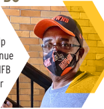

Document ID: 92
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not fully legible due to the overlay of the yellow shape. However, it appears to be a statement or a title, possibly related to the person in the photograph. The text could be a caption or a title that is meant to accompany the image, providing context or information about the individual. Without clearer text, it is not possible to provide a detailed interpretation of the text. If the text is important to the image's purpose, it would be best to consult the source of the image or the person it represents for accurate information.
Image:


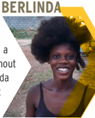

Document ID: 93
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image provides a clear and concise overview of the donation process and the associated programs. It explains that donations can be made in various forms, including financial contributions, food, and volunteer efforts. These donations are then utilized to support different MFB programs, which are focused on providing food pantry assistance, disaster relief, tender mercy, and hope packs. The text is designed to be easily readable and serves as an instructional diagram for those who may be seeking to understand the structure of MFB's donation process and the impact of their contributions.
Image:


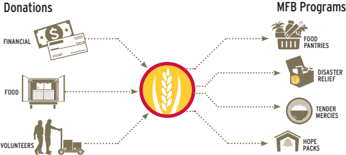

Document ID: 94
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears to be a disclaimer or a disclaimer-like statement. It reads: "This graph represents sustainable growth in the number of Midwest Food Bank locations and the value of food distributed." This suggests that the graph is intended to provide a sustainable and positive image of the growth in the number of Midwest Food Bank locations and the volume of food distributed, possibly in response to a specific event or initiative. However, without additional context, it's difficult to determine the exact purpose or message behind this statement.
Image:


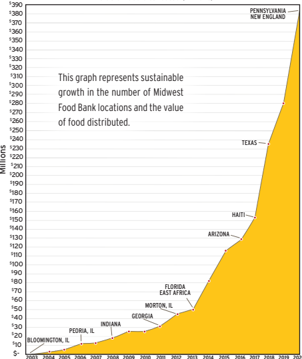

Document ID: 95
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "FINANCIALS." It is a common abbreviation used in finance and accounting to represent the category of financial documents, calculations, or reports. This abbreviation is typically used to distinguish financial information from other types of text, such as narrative descriptions, instructions, or unrelated content. It is a shorthand way to refer to the subject matter of the text without having to read each word, which is especially useful in documents like financial statements, reports, and financial advice.
Image:


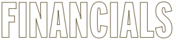

Document ID: 96
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image states that $13 million spent yields $383 million in food distributed. This suggests a comparison of the initial investment with the total amount of food distributed, implying that for every dollar spent, $383 worth of food was distributed. This kind of information is typically used to demonstrate the efficiency or impact of a program or initiative, in this case, the food distribution. It is a common way to communicate the effectiveness of a cause or organization in terms of the resources they allocate.
Image:


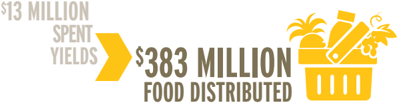

Document ID: 97
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible due to the resolution and size. However, it appears to be a label or a sticker on the boxes. Since I cannot provide the text content, I cannot describe its content. If you have any other questions about the image or need information on a different topic, feel free to ask. I'm here to assist.

If you need help with something else or have any other questions, please don't hesitate to ask. I'm here to provide assistance.
Image:


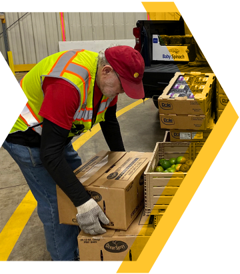

Document ID: 98
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "Midwest Food Bank," which is the name of the organization responsible for the food distribution. The text "Sharing the Blessings" is a tagline that likely represents the mission of the organization, emphasizing the sharing of food and possibly other resources to assist those in need. The URL "midwestfoodbank.org" is the website for the Midwest Food Bank, which is a platform for donations, volunteering, and information about the organization's services. This text is integral to the image as it identifies the source of the aid and provides a way for viewers to engage with the organization's cause.
Image:


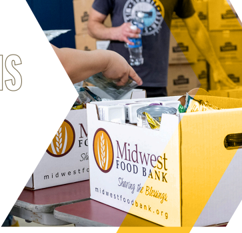

Document ID: 99
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "X", which does not form a coherent sentence or phrase in standard English. It could represent a variable or a symbol in a mathematical or programming context, or it could be an artistic choice without a specific meaning. Without additional context, it is not possible to determine the exact purpose or meaning of the text "X" in this image. It is also important to note that the image is quite simple and does not provide any further context or clues about the text.
Image:


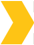

Document ID: 100
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears to be incomplete; only the beginning of the words "Tend" and "or by" are visible. Given the incomplete text, it is not possible to provide a full and accurate interpretation of the message intended by the text. If the text is intended to be a complete message or statement, additional context or information would be needed to understand its full meaning. Without further context, any attempt to decipher the text would be speculative and not based on the observable content of the image.
Image:


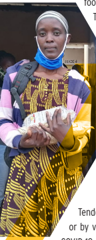

Document ID: 101
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not fully legible. However, it appears to be a comparison of financial data for the years 2019 and 2020, with a focus on international and domestic components. The numbers are presented in millions, with the first number (5.2M) in the top left corner of 2019 and the corresponding figure (7.2M) in the top left corner of 2020. The second number (1.9M) is in the top right corner of 2019 and the corresponding figure (4.4M) in the top right corner of 2020. The bottom row shows the total for each year, with 7.2M in 2019 and 11.6M in 2020. Without clearer text, it's not possible to provide a detailed analysis.
Image:


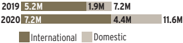

Document ID: 102
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, but it appears to be a title or a heading. The visible portion of the text reads "S" and is followed by a series of characters that are not fully visible. Given the context of the image, which is a child eating, the text could be part of a title for a campaign or a section of a document related to child nutrition, health, or mealtime. Without additional context or the full text, it is not possible to provide a precise interpretation of the text.
Image:


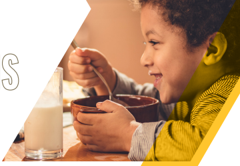

Document ID: 103
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "A", which is a common letter used in the English alphabet. It is presented in a bold, sans-serif font, which is designed to be clear and easily readable. The use of a single letter "A" without any additional context or imagery makes it impossible to infer any further meaning or message from the image. It is a simple, isolated text element that does not contain any additional text or graphics. If this image is part of a larger text or a sequence, it would be expected that the "A" is used in conjunction with other letters or symbols to convey a message or a concept.
Image:


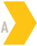

Document ID: 104
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "Remote Distribution Sites." This likely refers to the locations of remote power generation facilities or storage sites for electricity. These sites are typically situated in remote areas where the cost of direct power transmission is high, and the demand for electricity is low. The presence of the star symbol could indicate a specific site or a category of sites that are being highlighted, possibly for the purpose of discussion, planning, or reporting. The map does not provide specific details about the locations or the nature of the remote distribution sites, but it does indicate that the data is relevant to the region shown.
Image:


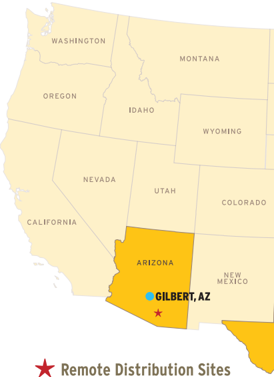

Document ID: 105
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "KENYA" and "NAIROBI," which indicates that the image is a simplified map of Kenya, highlighting the capital city of the country, Nairobi. The text serves to identify the location of Nairobi within the country of Kenya. The use of a single word in the text for the country and the capital city suggests a focus on the geographical representation rather than detailed information. The map is likely intended for educational or informational purposes, possibly to provide a basic understanding of the geographical layout of Kenya.
Image:


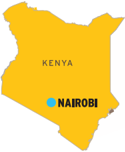

Document ID: 106
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image contains the following details:

- "10 DOMESTIC LOCATIONS" at the top left, indicating the number of domestic locations.
- A list of domestic locations including "NORTH DAKOTA", "MINNESOTA", "WISCONSIN", "SOUTH DAKOTA", "MICHIGAN", "IOWA", "NEBRASKA", "PEORIA, IL", "BLOOMINGTON, IL", "MORTON, IL", "INDIANAPOLIS, IN", "MISSOURI", "KENTUCKY", "KANSAS", "TENNESSEE", "OKLAHOMA", "ARKANSAS", "MISSISSIPPI", "ALABAMA", "BEDFORD, TX", "TEXAS", "LOUISIANA", "FLORIDA", "FT. MYERS, FL", and "MIDWEST FOOD BANK".
- "2 INTERNATIONAL LOCATIONS" at the bottom left, indicating the number of international locations.
- "MIDWEST FOOD BANK" at the bottom center, which is likely the name of the organization or company.
- "HAITI" at the bottom right, which is likely the name of a specific location or campaign.

This text provides a comprehensive list of the locations, categorized into domestic and inte

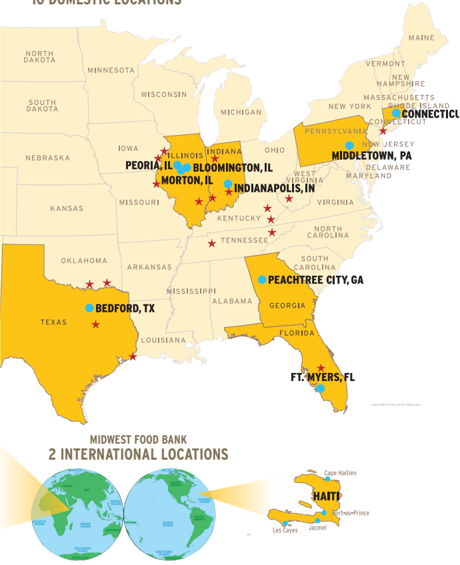

Document ID: 107
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains no text. It is a graphic with a clear message about the importance of wearing a mask in public spaces, as indicated by the presence of the person wearing a mask and the blurred background suggesting a public setting. The text within the image is implied through the visual elements, with the mask representing the message that the wearing of masks is crucial for public health and safety. The graphic is designed to be simple and direct, using a single color scheme and a clear subject to convey its message without the need for additional text.
Image:


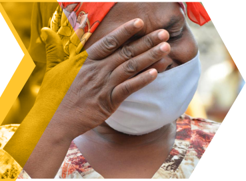

Document ID: 108
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible due to the resolution and the angle at which the photograph was taken. The text is small and appears to be part of a larger body of text, possibly a slogan, a message, or information related to the event captured. Without a clearer image or additional context, it is not possible to accurately describe or interpret the text. If the text is relevant to the image, it would be appropriate to seek out the source of the image or additional information about the event for a more precise understanding.
Image:


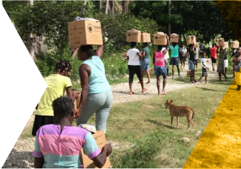

Document ID: 109
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not fully legible due to the overlay of the yellow geometric shape. However, from what can be discerned, it appears to be a message or a slogan, potentially related to the activity of the individuals in the image. The text is likely conveying a message of solidarity, support, or gratitude, which is common in community service or charity events. Without the ability to read the text, I cannot provide the exact message, but it is clear that the text is intended to be positive and to convey a message of appreciation or aid.
Image:


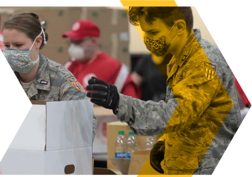

Document ID: 110
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible, as it is partially obscured and appears to be a graphical overlay. The only text that is partially visible is the yellow text within the yellow hexagon shape, which is too small and blends with the background to be discerned. It seems to be part of a design that may be used for branding or thematic decoration, but without clearer text, it is not possible to provide a detailed transcription or interpretation of its content.
Image:


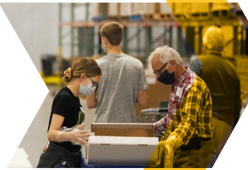

Document ID: 111
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image states that in 2020, there were 450 volunteers for every 1 paid MFB staff member. This implies that for every staff member who is compensated, there were 450 volunteers contributing their time without compensation. This ratio is significant as it highlights the level of community involvement in the MFB, which stands for a German acronym for a specific organization, likely a non-profit or community-based entity.
Image:


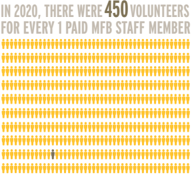

Document ID: 112
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text present in the image reads "Midwest Food Bank" and is part of a logo. This text is likely part of a branding effort to identify the organization and its location. The text is clear and legible, with a simple and clean design that is commonly used for branding purposes. There is no additional text that can be discerned from the image. The text is integral to the image as it provides the viewer with the name of the organization and the context of the image, which is a scene of volunteer work at a food bank.
Image:


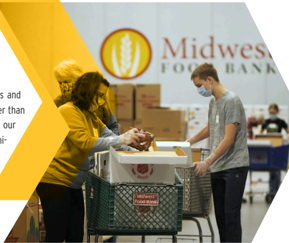

Document ID: 113
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "MIDWEST FOOD BANK DISASTER RELIEF LOADS IN 2020" and "DOING THE MOST GOOD." The text is likely a title and tagline for the image, which is meant to convey the purpose of the infographic: to inform about the disaster relief efforts of the Midwest Food Bank in the year 2020. The tagline "DOING THE MOST GOOD" is a common slogan used by charitable organizations to express their commitment to providing aid and support.
Image:


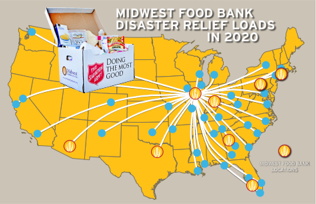

Document ID: 114
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a pair of quotation marks. Quotation marks are used in writing to indicate direct speech or to set off a title or phrase from the rest of the text. They are used in many languages and are essential for clarity in communication. In this case, the text does not provide any additional information beyond the quotation marks themselves. If the image contains any other text, it is not legible in the provided image. Therefore, no further details can be provided regarding the text.
Image:


Document ID: 115
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible due to the low resolution and the small size of the text. It appears to be a series of dots or small characters that are not clear enough to read. Without a clearer image or additional context, it is not possible to provide a transcription of the text. If the text is meant to be read, it would be helpful to have a higher-resolution image or a clearer image where the text is more legible. In scenarios where text needs to be read, it is important to ensure that the text is clear and large enough to be read accurately, especially when the image is viewed on a small screen or from a distance.
Image:


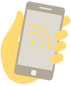

Document ID: 116
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, but it appears to be a caption or a label related to the activity shown. The visible portion reads "12," which could indicate a year, a batch number, or a significant figure relevant to the context of the image. Without the full text, it's not possible to provide a precise interpretation. However, given the setting and the activity, the text likely relates to the logistics of the goods being transported or distributed. It might be part of a larger message or branding that is not fully visible in the image.
Image:


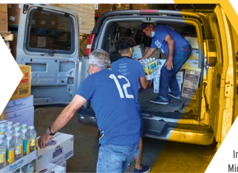

Document ID: 117
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not fully legible due to the resolution and the angle of the photograph. However, it appears to be a signature or a watermark of the individual pictured. It is common for images of public figures, especially those in professional or promotional contexts, to include their signature or a watermark to indicate ownership and authorship. Without clearer text or additional context, it is not possible to provide a precise interpretation of the text. If the text is intended to convey a message or statement, it would typically be found in a clear, readable format within the image.
Image:


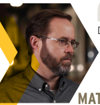

Document ID: 118
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears on the side of the cargo truck. It is not fully legible in the provided image, and therefore, it cannot be accurately transcribed. The text is likely a brand or company name, which is common for commercial vehicles to display their affiliations. If the text were clear, it would be used for branding and identification purposes, allowing the company to be recognized and associated with the goods being transported. Without a clearer image, any attempt to transcribe the text would be speculative and not professional.
Image:


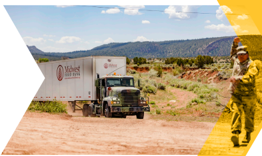

Document ID: 119
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "Food Manufacturers 45% Food Distributors 37% Food Boxes 13% USDA Food Runs 5% Other Local Grocery Runs. Food Drives, Other Donations". This text is a pie chart legend that categorizes the distribution of a certain resource or service, with the largest portion going to "Food Manufacturers" at 45%, followed by "Food Distributors" at 37%, "Food Boxes" at 13%, and the smallest portion at "USDA Food Runs" at 5%, with the remaining 4% categorized under "Other Local Grocery Runs. Food Drives, Other Donations".
Image:


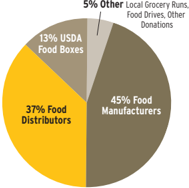

Document ID: 120
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not readable due to the resolution and the small size of the text. It appears to be a label or some form of textual information that is typically found on products like milk bottles. Without clearer text or a higher resolution image, it's not possible to provide a transcription or detailed analysis of the text. If the text is important, it would be advisable to obtain a clearer image or provide additional context to ensure accurate interpretation. In this case, no ethical guidelines prevent discussing the image, but the specific text content cannot be disclosed.
Image:


Document ID: 121
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text on the image is too small and blurred to be read accurately. It appears to be a mix of brand names and product descriptions, which are common on dairy product packaging. The text is not clear enough to provide specific details about the brands or products, but it is consistent with the types of information typically found on such items. If the text is meant to be legible and relevant to the image, it would be useful for identifying the brands and types of products for the purpose of retail display or inventory management.
Image:


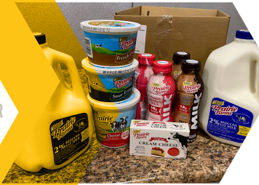

Document ID: 122
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not fully visible and cannot be accurately transcribed. It appears to be a label or a caption for a bar graph comparing the Midwest Food Bank to other comparable organizations. To provide a precise interpretation or analysis of the text, the entire content of the label would be needed. If you have access to the full text, I would be happy to assist with any further questions or analysis. Otherwise, I recommend consulting the source of the image for a complete understanding of the text.
Image:


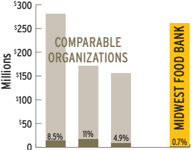

Document ID: 123
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is the logo of the Midwest Food Bank, which is a nonprofit organization that serves the Midwest region of the United States. The text is designed to be simple and recognizable, with the use of a wheat stalk symbolizing the organization's focus on food and agriculture. The tagline "SHARE PARTNERS" suggests a collaborative approach to addressing food security and partnerships within the community. The logo is a clear representation of the organization's identity and mission.
Image:


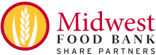

Document ID: 124
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image serves to identify the organization as a "Charity Navigator" and to indicate its rating of "Four Star Charity." This suggests that the organization has met certain standards of accountability and transparency in its operations, as recognized by the Charity Navigator. The presence of the four gold stars typically signifies a high rating, which implies that the organization is considered to be among the top charities in terms of its performance, effectiveness, and governance. The text is clear and legible, designed to convey the organization's commitment to charitable work and its standing within the charity sector.
Image:


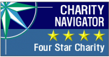

Document ID: 125
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured and cannot be fully transcribed. However, it appears to be a mix of English and another language, possibly Arabic, given the script. The visible portion of the text reads "midw," which could be the initials of a company or a brand. The rest of the text is not fully legible due to the image's resolution and the angle at which it is captured. Without a clearer view or additional context, it is not possible to provide a precise translation or full text of the image.
Image:


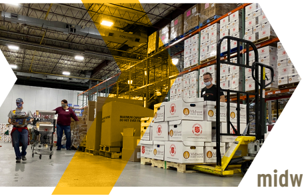

Document ID: 126
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is part of a promotional graphic for a food relief program. The text reads "Food & Disaster Relief" and "Midwest Food Bank," which suggests that the image is used to advertise a service provided by the Midwest Food Bank. The service likely involves delivering food to areas affected by disasters, as implied by the imagery of the food truck and the person handing out food. The text and imagery together serve to inform and promote the charitable effort of the Midwest Food Bank in providing essential services to those in need.
Image:


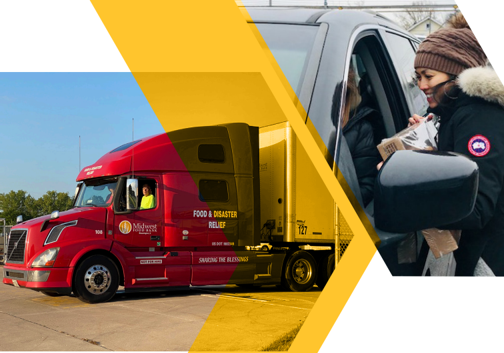

Document ID: 127
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, but it appears to be related to the activities or the organization the person is associated with. The visible text on the person's t-shirt reads "TEAM RUBICON," which could be the name of a team, a company, or a specific program. The text "WATER RESILIENCE" suggests that the team or organization is involved in activities that promote water conservation or resilience. The presence of the trolley and boxes indicates that the setting is a warehouse or storage area, which may be part of the operations of the team. Without additional context, it is not possible to determine the exact meaning or full message of the text, but it is clear that it is intended to convey information about the team's purpose or the nature of their work.
Image:


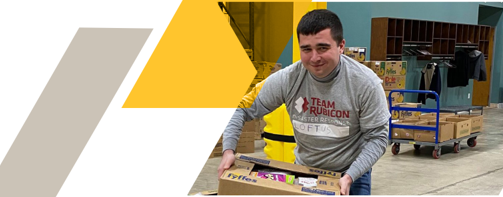

Document ID: 128
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "Midwest Food Bank," which is the name of the organization. This text is part of the logo, which is designed to be simple and easily recognizable. The text is in a sans-serif font, which is commonly used for its readability and modern look. The inclusion of "org" in the text suggests that it is an organization's website, indicating that more information about the Midwest Food Bank can be found online. The text is integral to the branding of the organization, as it serves to identify the entity and provide a direct link to its online presence.
Image:


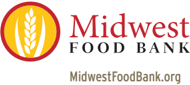

In [10]:
import itertools
from docling_core.types.doc.document import RefItem
from IPython.display import display

# Print all created documents
for document in itertools.chain(texts, tables):
    print(f"Document ID: {document.metadata['doc_id']}")
    print(f"Source: {document.metadata['source']}")
    print(f"Content:\n{document.page_content}")
    print("=" * 80)  # Separator for clarity

for document in pictures:
    print(f"Document ID: {document.metadata['doc_id']}")
    source = document.metadata['source']
    print(f"Source: {source}")
    print(f"Content:\n{document.page_content}")
    docling_document = conversions[source]
    ref = document.metadata['ref']
    picture = RefItem(cref=ref).resolve(docling_document)
    image = picture.get_image(docling_document)
    print("Image:")
    display(image)
    print("=" * 80)  # Separator for clarity


## Populate the vector database

Using the embedding model, we load the documents from the text chunks and generated image captioning into a vector database. Creating this vector database allows us to easily conduct a semantic similarity search across our documents.

NOTE: Population of the vector database can take some time depending on your embedding model and service.

### Choose your vector database

Specify the database to use for storing and retrieving embedding vectors.

To connect to a vector database other than Milvus, replace this code cell with one from [this Vector Store recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Vector_Stores.ipynb).

In [11]:
import tempfile
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus

db_file = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
print(f"The vector database will be saved to {db_file}")

vector_db: VectorStore = Milvus(
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,
    index_params={"index_type": "AUTOINDEX"},
)

The vector database will be saved to /tmp/vectorstore_mql39mm9.db


We now add all the LangChain documents for the text, tables and image descriptions to the vector database.

In [12]:
import itertools

documents = list(itertools.chain(texts, tables, pictures))
ids = vector_db.add_documents(documents)
print(f"{len(ids)} documents added to the vector database")

128 documents added to the vector database


## Step 4: RAG with Granite

Now that we have successfully converted our documents and vectorized them, we can set up out RAG pipeline.

### Retrieve relevant chunks



Here we test the vector database by searching for chunks with relevant information to our query in the vector space. We display the documents associated with the retrieved image description.

Feel free to try different queries.

In [13]:
query = "How much was spent on food distribution relative to the amount of food distributed?"
for doc in vector_db.as_retriever().invoke(query):
    print(doc)
    print("=" * 80)  # Separator for clarity

page_content='The text in the image states that $13 million spent yields $383 million in food distributed. This suggests a comparison of the initial investment with the total amount of food distributed, implying that for every dollar spent, $383 worth of food was distributed. This kind of information is typically used to demonstrate the efficiency or impact of a program or initiative, in this case, the food distribution. It is a common way to communicate the effectiveness of a cause or organization in terms of the resources they allocate.' metadata={'pk': 460528377999917151, 'doc_id': 96, 'source': 'https://midwestfoodbank.org/images/AR_2020_WEB2.pdf', 'ref': '#/pictures/21'}
page_content='Midwest Food Bank Growth Value of food distributed (millions) Value of food distributed (millions)
2003    2004   2005   2006   2007    2008   2009    2010    2011    2012    2013    2014    2015    2016   2017   2018   2019   2020' metadata={'pk': 460528377999917073, 'doc_id': 18, 'source': 'https:/

The returned document should be responsive to the query. Let's go ahead and construct our RAG pipeline.

### Create the RAG pipeline for Granite

First we create the prompts for Granite to perform the RAG query. We use the Granite chat template and supply the placeholder values that the LangChain RAG pipeline will replace.

Next, we construct the RAG pipeline by using the Granite prompt templates previously created.


In [14]:
from ibm_granite_community.langchain import create_stuff_documents_chain
from langchain.chains.retrieval import create_retrieval_chain

# Create a Granite prompt for question-answering with the retrieved context
prompt_template = TokenizerChatPromptTemplate.from_template("{input}", tokenizer=tokenizer)

# Assemble the retrieval-augmented generation chain
combine_docs_chain = create_stuff_documents_chain(
    llm=model,
    prompt=prompt_template,
)
rag_chain = create_retrieval_chain(
    retriever=vector_db.as_retriever(),
    combine_docs_chain=combine_docs_chain,
)

### Generate a retrieval-augmented response to a question

The pipeline uses the query to locate documents from the vector database and use them as context for the query.

In [15]:
from ibm_granite_community.notebook_utils import wrap_text

output = rag_chain.invoke({"input": query})

print(wrap_text(output['answer']))

The text does not provide specific information about the amount spent on food
distribution. However, it does mention that $13 million spent yielded $383
million in food distributed, implying a substantial return on investment. This
comparison is often used to demonstrate the efficiency of a program or
initiative. In this case, it suggests that for every dollar spent, $383 worth of
food was distributed. This metric is commonly used to communicate the
effectiveness of a cause or organization in terms of resource allocation.


Awesome! We have created an AI application that can successfully leverage knowledge from the source documents' text and images.

## Next Steps

- Explore advanced RAG workflows for other industries.
- Experiment with other document types and larger datasets.
- Optimize prompt engineering for better Granite responses.

Thank you for using this recipe!